In [1]:
import os                                                           
                                                                    
import glob                                                         
from hdbscan import HDBSCAN                                         
import matplotlib.pyplot as plt                                     
from metric_learn import *                                          
from mpl_toolkits.mplot3d import Axes3D                             
import numpy as np                                                  
import pandas as pd                                                 
import seaborn as sns                                               
from sklearn import metrics                                         
from sklearn.cluster import DBSCAN                                  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing                                   
import tensorflow as tf                                             
import tqdm                                                         
                                                                    
from trackml.dataset import load_event, load_dataset                
from trackml.score import score_event                               
                                                                    
import operator                                                     

In [7]:
def parse(truth, min_num=5, max_num=16):
    truth_dedup = truth.drop_duplicates('particle_id')
    #truth_sort = truth_dedup.sort_values('weight', ascending=False)

    p_traj_list = []
    p_traj_clean_list = []
    for i, (_, tr) in enumerate(truth_dedup.iterrows()):
        p_traj = truth[truth.particle_id == tr.particle_id][[
            'tx', 'ty', 'tz'
        ]].reset_index(drop=True)
        p_id = pd.DataFrame(
            np.ones((p_traj.shape[0], 1), dtype=np.int) * i, columns=['id'])
        p_traj_id = pd.concat((p_traj, p_id), axis=1)
        p_traj_list.append(p_traj_id)

        if min_num < p_traj.shape[0] and p_traj.shape[0] < max_num:
            p_traj_clean_list.append(p_traj_id)

    p_traj_df = pd.concat(p_traj_list, ignore_index=True)
    p_traj_clean_df = pd.concat(p_traj_clean_list, ignore_index=True)

    return p_traj_df, p_traj_clean_df

def compute_x2(xyz, prefix='t'):
    x = xyz[prefix + 'x'].values
    y = xyz[prefix + 'y'].values
    z = xyz[prefix + 'z'].values
    r = np.sqrt(x**2 + y**2 + z**2)
    xyz[prefix + 'x2'] = x / r
    xyz[prefix + 'y2'] = y / r
    r = np.sqrt(x**2 + y**2)
    xyz[prefix + 'z2'] = z / r

In [9]:
p_traj_clean_all = []                                         
hits_all = []                                                 
end_id = 0                                                    
for i, (event_id, hits, cells, particles, truth) in tqdm.tqdm(
        enumerate(load_dataset('../input/train_1', skip=0))): 
    _, p_traj_clean_df = parse(truth)                         
    p_traj_clean_df['id'] += end_id                           
    end_id = p_traj_clean_df['id'].values[-1]                 
    compute_x2(p_traj_clean_df)                               
    compute_x2(hits, prefix='')                               
    p_traj_clean_all.append(p_traj_clean_df)                  
                                                              
    hits_all.append(hits)                                     
    if i > -1:                                                
        break                                                 




0it [00:00, ?it/s]

In [10]:
p_traj_clean_cat = pd.concat(p_traj_clean_all, ignore_index=True) 
hits_cat = pd.concat(hits_all, ignore_index=True)                 

In [34]:
scl = preprocessing.StandardScaler()                                    
# clf = LinearDiscriminantAnalysis(n_components=3)                   
clf = LFDA(dim=3, k=3)                                                         
# clf = NCA()                                                           
# clf = LMNN(k=2)                                                       
# clf = RCA_Supervised()                                                
X_cols = ('x', 'y', 'z', 'x2', 'y2', 'z2')         
tX_cols = ('tx', 'ty', 'tz', 'tx2', 'ty2', 'tz2')  
# X_cols = ('x2', 'y2', 'z2')                                           
# tX_cols = ('tx2', 'ty2', 'tz2')                                       
                                                                        
p_traj_clean_cat = pd.concat(p_traj_clean_all, ignore_index=True)       
hits_cat = pd.concat(hits_all, ignore_index=True)                       
                                                                        
X_scale = scl.fit_transform(hits_cat.loc[:, X_cols].values)             
X_clean_scale = scl.transform(p_traj_clean_cat.loc[:, tX_cols].values)  
clf.fit(X_clean_scale, p_traj_clean_cat['id'].values)
X_trans = pd.DataFrame(clf.transform(X_clean_scale), columns=['x', 'y', 'z'])
X_trans = pd.concat((X_trans, p_traj_clean_cat['id']),  axis=1)
print(X_trans.shape)

(94776, 3)
(94776, 4)


Text(0.5,0.92,'Trajectories of top weights particles in Cartesian coordinates.')

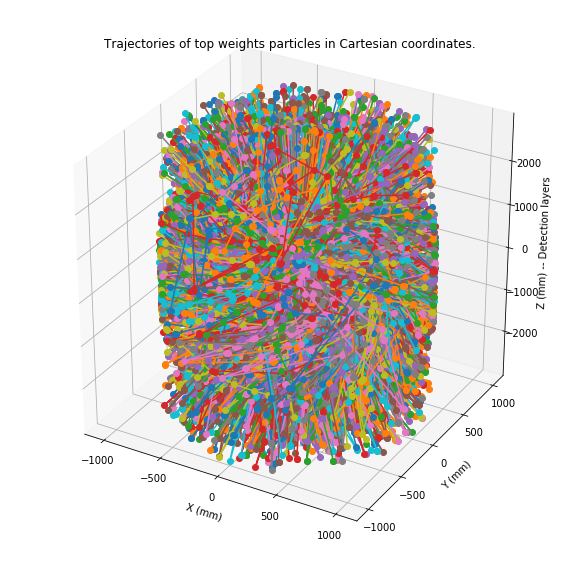

In [17]:
# Plot with Cartesian coordinates.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for idx in p_traj_clean_cat['id'].unique():
    p_traj = p_traj_clean_cat.loc[p_traj_clean_cat['id'] == idx,:]
    ax.plot(
        xs=p_traj.tx,
        ys=p_traj.ty,
        zs=p_traj.tz,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in Cartesian coordinates.')

Text(0.5,0.92,'Trajectories of top weights particles in Cartesian coordinates.')

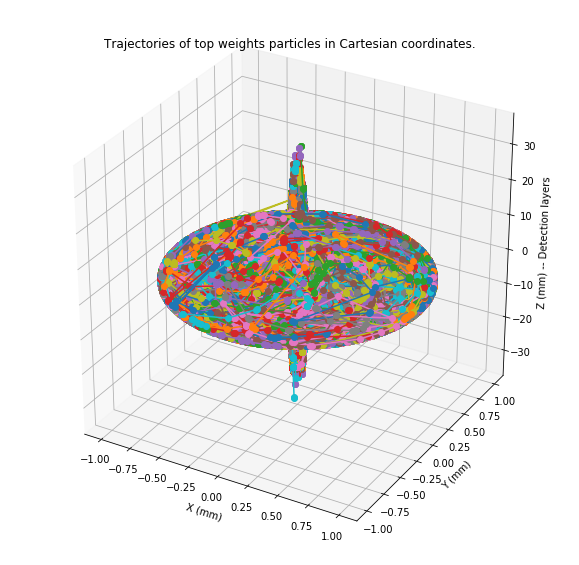

In [18]:
# Plot with Cartesian coordinates.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for idx in p_traj_clean_cat['id'].unique():
    p_traj = p_traj_clean_cat.loc[p_traj_clean_cat['id'] == idx,:]
    ax.plot(
        xs=p_traj.tx2,
        ys=p_traj.ty2,
        zs=p_traj.tz2,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in Cartesian coordinates.')

Text(0.5,0.92,'Trajectories of top weights particles in Cartesian coordinates.')

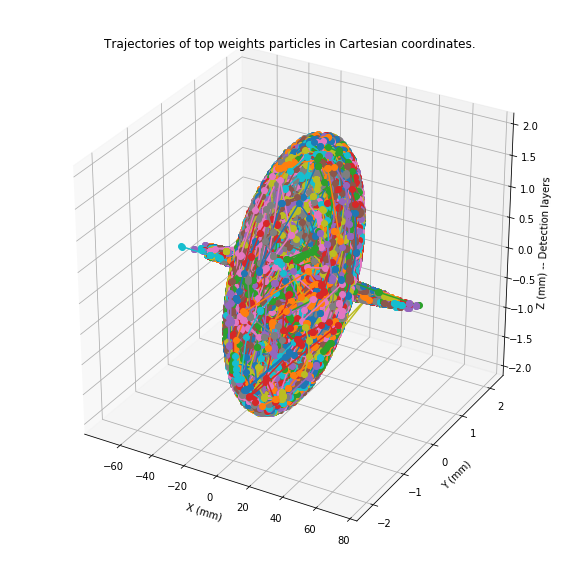

In [35]:
# Plot with Cartesian coordinates.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for idx in X_trans['id'].unique():
    p_traj = X_trans.loc[X_trans['id'] == idx,:]
    ax.plot(
        xs=p_traj.x,
        ys=p_traj.y,
        zs=p_traj.z,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in Cartesian coordinates.')